In [1]:
import random as rand
import math

import pandas as pd
import numpy as np

import matplotlib.pyplot as plt

import os.path as osp

In [2]:
# data = pd.read_csv(osp.join('.', 'StudentPerformanceFactors.csv'))
data = pd.read_csv(osp.join('.', 'Data', 'preprocessed.csv'))
# data.set_index('Employee_ID', inplace=True)
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5836 entries, 0 to 5835
Data columns (total 20 columns):
 #   Column                      Non-Null Count  Dtype 
---  ------                      --------------  ----- 
 0   Hours_Studied               5836 non-null   int64 
 1   Attendance                  5836 non-null   int64 
 2   Parental_Involvement        5836 non-null   object
 3   Access_to_Resources         5836 non-null   object
 4   Extracurricular_Activities  5836 non-null   object
 5   Sleep_Hours                 5836 non-null   int64 
 6   Previous_Scores             5836 non-null   int64 
 7   Motivation_Level            5836 non-null   object
 8   Internet_Access             5836 non-null   object
 9   Tutoring_Sessions           5836 non-null   int64 
 10  Family_Income               5836 non-null   object
 11  Teacher_Quality             5836 non-null   object
 12  School_Type                 5836 non-null   object
 13  Peer_Influence              5836 non-null   obje

# Draw Functions

In [3]:
def scatter_plot(data: pd.DataFrame, x: str, y: str, ax, groups:str = None, *,
                 xlabel: bool = True, ylabel: bool = True,
                 alpha: float = 1):
    
    ax.scatter(data[x], data[y], alpha=alpha)

    if xlabel: ax.set_xlabel(x)
    if ylabel: ax.set_ylabel(y)
def scatter_grid(data: pd.DataFrame, xs: list[str], ys: list[str], fig,
                 groups: str = None, *, alpha: float = 1):
    xsize = len(xs)
    ysize = len(ys)
    for i, y in enumerate(ys):
        for j, x in enumerate(xs):
            ax = fig.add_subplot(ysize, xsize, i * xsize + j + 1)

            if i != ysize - 1: xlabel = False
            else: xlabel = True

            if j != 0: ylabel = False
            else: ylabel = True

            scatter_plot(data, x, y, ax, groups,
                         xlabel=xlabel, ylabel=ylabel,
                         alpha=alpha)
    fig.tight_layout()

def bar_group(data: pd.DataFrame, category1: str, category2: str, ax):
    def sort_func(s):
        # sort func to pass as key to the groupby object later on.
        # NOTE: s is an Index object!
        cat_to_use = first_categories if s.name == category1 else second_categories
        return [np.where(cat_to_use == val)[0][0] for val in s]

    first_categories = data[category1].unique()
    second_categories = data[category2].unique()

    gp2_data = data.reset_index().groupby(category1).count()['index']
    gp_data = data.reset_index().groupby([category1, category2])\
                                .count()['index']\
                                .sort_index(key=sort_func)\
                                .astype('float64')
    
    for category in first_categories:
        for cat2 in second_categories:
            gp_data[category, cat2] = gp_data[category, cat2] / gp2_data[category]
        
    gp_data.reset_index()\
           .pivot_table(values='index', index=category1, columns=category2)\
           .plot(kind='bar', stacked=True, ax=ax)
    
    ax.legend(title=category2)
    ax.set_xlabel(category1)
    ax.set_ylabel('Percentage in group')
def hist_group(data: pd.DataFrame, groups: str, value:str, ax):
    for group in data[groups].unique():
        ax.hist(data[data[groups] == group][value], label=group,
                 histtype='step', density=True)

    ax.set_xlabel(value)
    ax.set_ylabel('Density')
    ax.legend(title=groups)
    ax.grid()

def boxplot(data: pd.DataFrame, category_variable: str, measure_var: str, ax):
    boxes = [data[data[category_variable] == category][measure_var]
             for category in data[category_variable].unique()]
    ax.boxplot(boxes, tick_labels=data[category_variable].unique())
    ax.set_xlabel(category_variable)
    ax.set_ylabel(measure_var)

# Hypothesis Test Functions

In [7]:
from scipy.stats import chi2_contingency, f_oneway, levene, t
from statsmodels.stats.multicomp import pairwise_tukeyhsd

from pingouin import welch_anova

from typing import Literal, Any

In [8]:
def chi2_categoric(df: pd.DataFrame, var1: str, var2: str):
    table = df.pivot_table(index=var1, columns=var2, aggfunc='count')
    table = table[table.columns[:len(df[var2].unique())]]
    return chi2_contingency(table)
def oneway_anova(df: pd.DataFrame, dependent_var: str, categoric_var: str, alpha: float) -> dict[Literal['levene', 'anova', 'tukey'], Any]:
    categories = [df[df[categoric_var] == category][dependent_var]
                  for category in df[categoric_var].unique()]
    return {'levene': levene(*categories),
            'anova': f_oneway(*categories),
            'tukey': pairwise_tukeyhsd(df[dependent_var], df[categoric_var], alpha=alpha)}

# Kiểm Định Tương Quan

In [6]:
ALPHA = .05

In [ ]:
# Target: Exam_Score

# # Numeric:
# Previous_Scores\
# Hours_Studied\
# Attendance                  (%)\
# Sleep_Hours                 (/night)\
# Tutoring_Sessions           (sessions/month)\
# Physical_Activity           (hours/week)

# # Categoric:
# Parental_Involvement        ('Low', 'Medium', 'High')\
# Access_to_Resources         ('Low', 'Medium', 'High')\
# Motivation_Level            ('Low', 'Medium', 'High')\
# Family_Income               ('Low', 'Medium', 'High')\
# Teacher_Quality             ('Low', 'Medium', 'High')\

# Extracurricular_Activities  ('Yes', 'No')\
# Internet_Access             ('Yes', 'No')\
# Learning_Disabilities       ('Yes', 'No')\
# School_Type                 ('Public', 'Private')\
# Gender                      ('Male', 'Female')

# Peer_Influence              ('Positive', 'Neutral', 'Negative')\
# Parental_Education_Level    ('High School', 'College', 'Postgraduate')\
# Distance_from_Home          ('Near', 'Moderate', 'Far')

## Tương quan giữa các biến định lượng
Sử dụng Pearson

In [9]:
numeric_only = ['Previous_Scores', 'Hours_Studied',
                'Attendance', 'Sleep_Hours',
                'Tutoring_Sessions', 'Physical_Activity', 'Exam_Score']
corr_mat = data[numeric_only].corr('pearson')
corr_mat

,Previous_Scores,Hours_Studied,Attendance,Sleep_Hours,Tutoring_Sessions,Physical_Activity,Exam_Score
Previous_Scores,1.000000,0.011353,-0.024971,-0.019977,-0.025197,-0.007089,0.198381
Hours_Studied,0.011353,1.000000,-0.027202,0.012182,-0.012270,-0.004949,0.501905
Attendance,-0.024971,-0.027202,1.000000,-0.022332,0.004272,-0.032490,0.684015
Sleep_Hours,-0.019977,0.012182,-0.022332,1.000000,-0.002413,0.000437,-0.009032
Tutoring_Sessions,-0.025197,-0.012270,0.004272,-0.002413,1.000000,-0.017420,0.139970
Physical_Activity,-0.007089,-0.004949,-0.032490,0.000437,-0.017420,1.000000,0.027836
Exam_Score,0.198381,0.501905,0.684015,-0.009032,0.139970,0.027836,1.000000


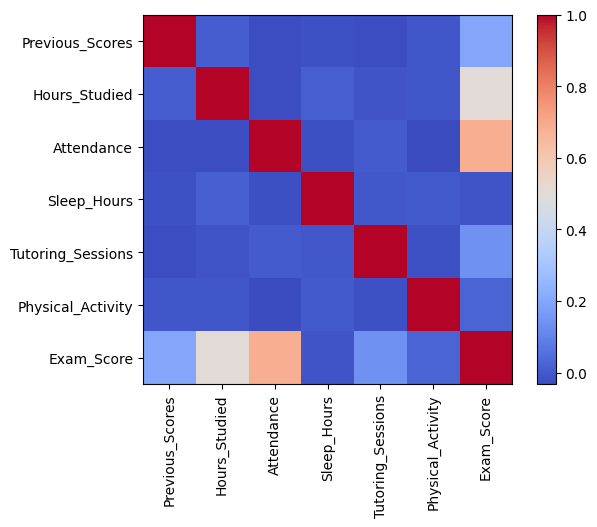

In [10]:
plt.imshow(corr_mat, 'coolwarm')
plt.colorbar()
plt.xticks(range(len(numeric_only)), numeric_only, rotation='vertical')
plt.yticks(range(len(numeric_only)), numeric_only)
plt.show()

=> Tương quan mạnh giữa Hours_Studied, Attendance và Exam_Score

Kiểm định ý nghĩa thống kê của hệ số Pearson

In [11]:
pear_hours = corr_mat['Hours_Studied']['Exam_Score']
pear_attend = corr_mat['Attendance']['Exam_Score']
dof = len(data) - 2

t_hours = pear_hours * np.sqrt(dof) / np.sqrt(1 - pear_hours ** 2)
t_attend = pear_attend * np.sqrt(dof) / np.sqrt(1 - pear_attend ** 2)

p_hours = 2 * (1 - t.cdf(t_hours, dof))
p_attend = 2 * (1 - t.cdf(t_attend, dof))

print(f"p-values:\n{p_hours=:.4e}\n{p_attend=:.4e}")

p-values:
p_hours=0.0000e+00
p_attend=0.0000e+00


Cả hai đều có p_value < 5% => hệ số Pearson != 0\
=> hai biến có tương quan với Exam_Score với mức ý nghĩa 5%

## Tương quan giữa các biến định danh
Sử dụng kiểm định Chi^2

In [12]:
categoric = ['Parental_Involvement',
             'Access_to_Resources', 'Motivation_Level',
             'Family_Income', 'Teacher_Quality',
             'Extracurricular_Activities', 'Internet_Access',
             'Learning_Disabilities', 'School_Type', 'Gender',
             'Peer_Influence', 'Parental_Education_Level',
             'Distance_from_Home']

pv_mat = np.ones((len(categoric), len(categoric)))
pv_mat = -1 * pv_mat
for i, cat1 in enumerate(categoric[:-1]):
    for j in range(i + 1, len(categoric)):
        result = chi2_categoric(data, cat1, categoric[j])
        if result.pvalue < ALPHA: pv_mat[j, i] = result.pvalue

Ma trận đại diện cho cặp biến bác bỏ H0\
Các biến tô màu xanh dương có p_value >= 5%

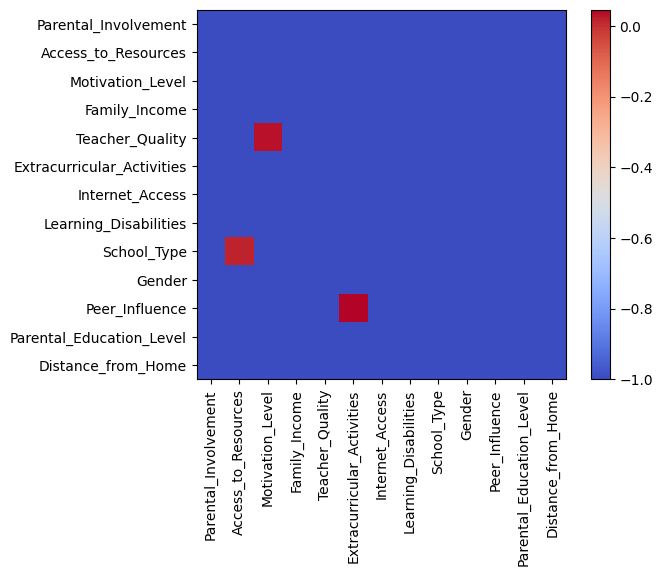

In [13]:
plt.imshow(pv_mat, 'coolwarm')
plt.colorbar()
plt.xticks(range(len(categoric)), categoric, rotation='vertical')
plt.yticks(range(len(categoric)), categoric)
plt.show()

Cặp biến định danh có tương quan:
- Access_to_Resources & School_Type
- Motivation_Level & Teacher Quality
- Peer_Influence & Extracurricular Activities

## Tương quan giữa biến định danh với biến mục tiêu Exam_Score
Sử dụng Oneway-ANOVA

In [14]:
categoric = ['Parental_Involvement',
             'Access_to_Resources', 'Motivation_Level',
             'Family_Income', 'Teacher_Quality',
             'Extracurricular_Activities', 'Internet_Access',
             'Learning_Disabilities', 'School_Type', 'Gender',
             'Peer_Influence', 'Parental_Education_Level',
             'Distance_from_Home']
length = len(max(categoric, key=len))
anova_results = {}

print(f"{'Variable':<{length}} | {'Levene':^10} || {'ANOVA':^10}")
print('=' * len(f"{'Variable':<{length}} | {'Levene':^10} -- {'Anova':^10}"))
for feature in categoric:
    anova_results[feature] = oneway_anova(data, 'Exam_Score', feature, alpha=ALPHA)
    print(f"{feature:<{length}} |",
          f"{anova_results[feature]['levene'].pvalue:.4e} ||",
          f"{anova_results[feature]['anova'].pvalue:.4e}")

Variable                   |   Levene   ||   ANOVA   
Parental_Involvement       | 7.8899e-01 || 6.0580e-42
Access_to_Resources        | 2.5566e-02 || 1.4512e-44
Motivation_Level           | 1.9481e-01 || 3.2555e-12
Family_Income              | 9.5150e-01 || 1.0776e-12
Teacher_Quality            | 5.1119e-01 || 1.0183e-08
Extracurricular_Activities | 5.4288e-01 || 3.0812e-08
Internet_Access            | 2.8271e-01 || 2.3151e-07
Learning_Disabilities      | 6.3928e-01 || 9.2108e-17
School_Type                | 8.0542e-01 || 2.2188e-01
Gender                     | 4.0707e-01 || 4.2493e-01
Peer_Influence             | 2.2172e-01 || 5.4519e-20
Parental_Education_Level   | 3.9032e-01 || 3.9543e-23
Distance_from_Home         | 5.6975e-01 || 3.2631e-13


Access_to_Resources bác bỏ giả thuyết phương sai giữa các nhóm là khác nhau\
=> Sử dụng Welch's test

In [ ]:
welch_anova(data, dv='Exam_Score', between='Access_to_Resources')

,Source,ddof1,ddof2,F,p-unc,np2
0,Access_to_Resources,2,2931.741082,104.10213,2.100024e-44,0.034018


=> Gender, School_Type không tương quan với Exam_Score\
=> Quan tâm đến Access_to_Resources, Learning_Disabilities, Parental_Education_Level, Parental_Involvement, Peer_Influence

Hậu kiểm cho năm biến trên

In [17]:
temp = ['Access_to_Resources', 'Learning_Disabilities', 'Parental_Education_Level',
        'Parental_Involvement', 'Peer_Influence']
for var in temp:
    print(f"Post-hoc Tukey for {var}:")
    print(anova_results[var]['tukey'])
    print()

Post-hoc Tukey for Access_to_Resources:
Multiple Comparison of Means - Tukey HSD, FWER=0.05
group1 group2 meandiff p-adj  lower   upper  reject
---------------------------------------------------
  High    Low  -1.6924   0.0 -1.9744 -1.4103   True
  High Medium  -0.9068   0.0 -1.1321 -0.6815   True
   Low Medium   0.7856   0.0  0.5277  1.0435   True
---------------------------------------------------

Post-hoc Tukey for Learning_Disabilities:
Multiple Comparison of Means - Tukey HSD, FWER=0.05
group1 group2 meandiff p-adj  lower   upper  reject
---------------------------------------------------
    No    Yes  -1.1586   0.0 -1.4309 -0.8862   True
---------------------------------------------------

Post-hoc Tukey for Parental_Education_Level:
     Multiple Comparison of Means - Tukey HSD, FWER=0.05      
   group1      group2    meandiff p-adj  lower   upper  reject
--------------------------------------------------------------
    College  High School  -0.4701   0.0 -0.6969 -0.2434   

# Biểu diễn

## Tương quan giữa Hours_Studied, Attendance với Exam_Score

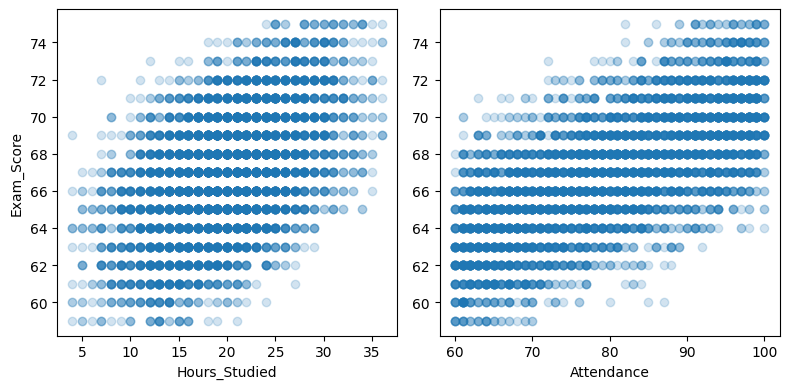

In [4]:
scatter_grid(data, ['Hours_Studied', 'Attendance'], ['Exam_Score'], plt.figure(figsize=(8, 4)), alpha=.2)

## Tương quan giữa năm biến định danh được nêu ở phần kiểm định với Exam_Score

Boxplot mô tả sự khác biệt điểm số giữa các nhóm trong biến

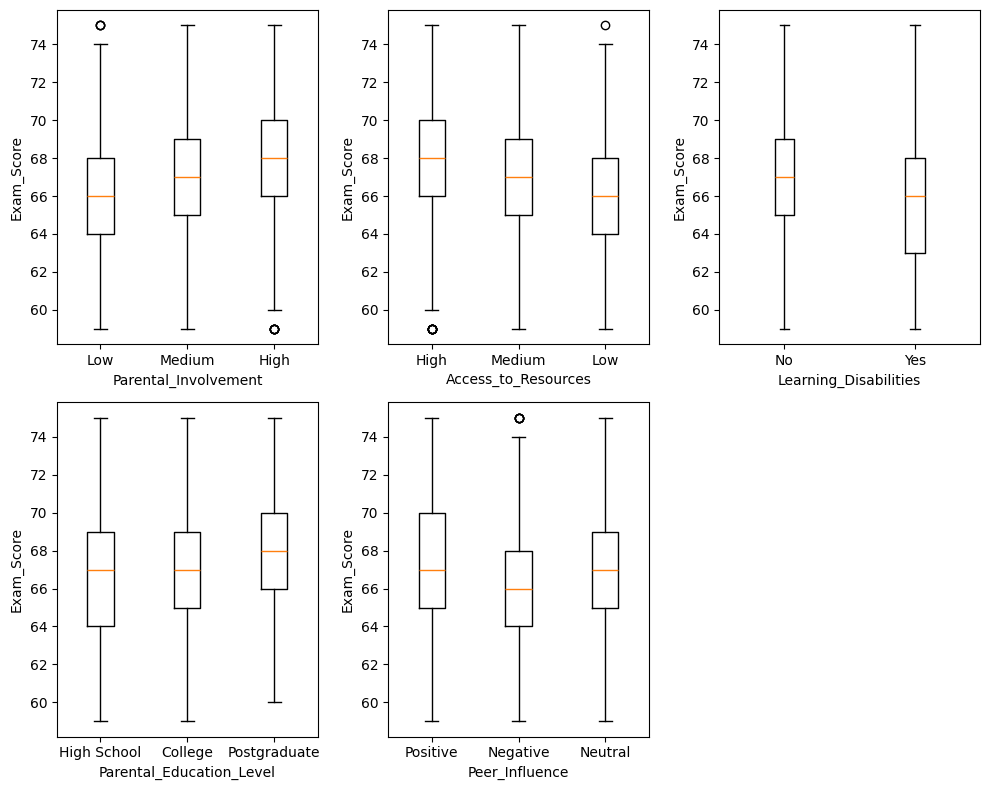

In [5]:
cols = ['Parental_Involvement', 'Access_to_Resources',
        'Learning_Disabilities', 'Parental_Education_Level',
        'Peer_Influence']

fig = plt.figure(figsize=(10, 8))
boxplot(data, cols[0], 'Exam_Score', fig.add_subplot(2, 3, 1))
boxplot(data, cols[1], 'Exam_Score', fig.add_subplot(2, 3, 2))
boxplot(data, cols[2], 'Exam_Score', fig.add_subplot(2, 3, 3))
boxplot(data, cols[3], 'Exam_Score', fig.add_subplot(2, 3, 4))
boxplot(data, cols[4], 'Exam_Score', fig.add_subplot(2, 3, 5))

fig.axes[0].set_xlabel(cols[0])
fig.axes[1].set_xlabel(cols[1])
fig.axes[2].set_xlabel(cols[2])
fig.axes[3].set_xlabel(cols[3])
fig.axes[4].set_xlabel(cols[4])

fig.tight_layout()

Parental_Education_Level: High School và College tương đối giống => gộp lại\
Peer_Influence: tương tự, gộp Positive và Neutral

Mô tả chi tiết phân phối giữa các nhóm trong biến Parental_Involvement và Access_to_Resources

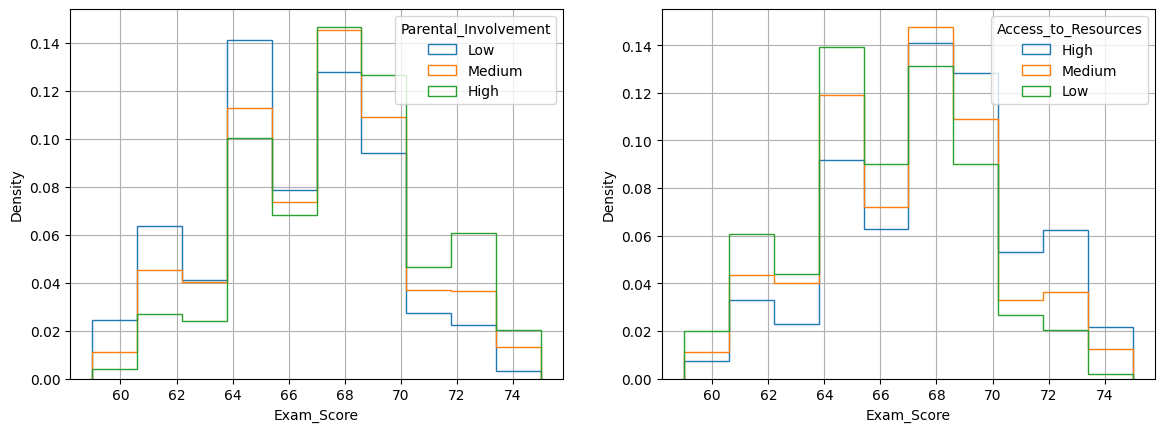

In [27]:
fig = plt.figure(figsize=(14, 4.8))
hist_group(data, cols[0], 'Exam_Score', fig.add_subplot(1, 2, 1))
hist_group(data, cols[1], 'Exam_Score', fig.add_subplot(1, 2, 2))

fig.axes[0].legend(title=cols[0], loc='upper right')
fig.axes[1].legend(title=cols[1], loc='upper right')
# hist_group(data, cols[0], 'Exam_Score', plt.gca())

# plt.legend(title=cols[0], loc='upper right')
# plt.gcf().get_size_inches()

## Tương quan giữa ba cặp biến định danh được nêu ở phần kiểm định Chi^2

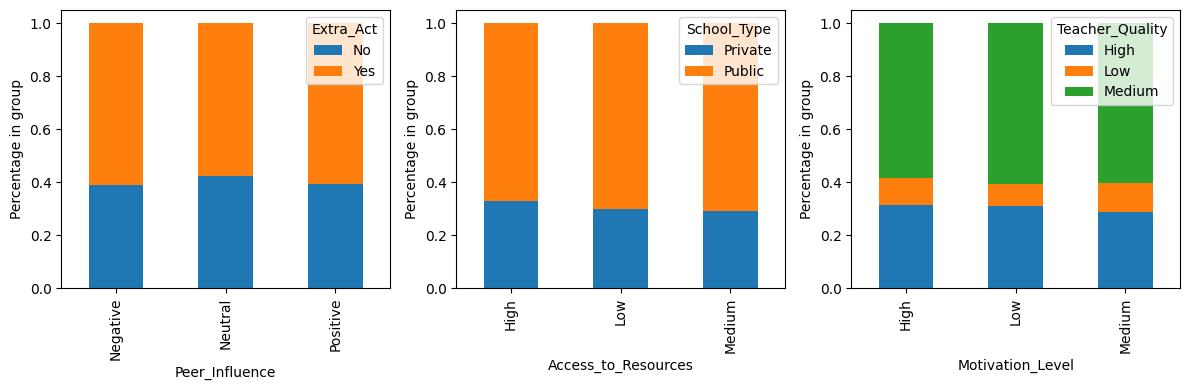

In [ ]:
fig = plt.figure(figsize=(12, 4))
bar_group(data, 'Peer_Influence', 'Extracurricular_Activities', fig.add_subplot(1, 3, 1))
bar_group(data, 'Access_to_Resources', 'School_Type', fig.add_subplot(1, 3, 2))
bar_group(data, 'Motivation_Level', 'Teacher_Quality', fig.add_subplot(1, 3, 3))

fig.axes[0].legend(title='Extra_Act')
fig.tight_layout()